# CNN-LSTM

CNN-LSTM based model.

## Initialization

Import needed packages, initialize model parameters and configure folder and file paths.

### Imports

Import necessary python packages.

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import csv
import shutil

from sklearn.model_selection import train_test_split
from sklearn import metrics
from keras import preprocessing, models, layers, callbacks, utils
from mlxtend.plotting import plot_confusion_matrix
from IPython.display import SVG

# set tensorflow logging
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '0'

### Parameters initialization

Initialize model parameters, file and folder used by the model.

#### Model parameters

Initialize model related parameters. 

Increment the model version with every change of the model configuration. This will result in the tokenizer, and model version being saved in a seperate files that can be later loaded and reused/re-evaluated. To test and evaluate an already trained model version, change the version parameter and skip to section 4: Model Validation. 

Don't forget to commit the model to git after each version increment, this way the state of the notebook that was used to train the given model version can be easily reverted to.

The `template_version` variable represents the version of the template notebook used as a base for this model.

`train_data_csv`, `test_data_csv` and `sts_gold_test_csv` point to the location of the processed training and test datasets used to train and validate the model

In [3]:
# model information
model_name = 'CNN-LSTM'
model_version = 'final'
train_data_version = '0.2'
template_version = '3.0'

# model parameters
max_features = 50000
max_words = 50
CNN_size = 200
CNN_strides = 5
batch_size = 512
embedding_dimensions = 256
pool_size = 1
LSTM_size = 32
epochs = 4

# dataset file locations
train_data_csv = '../../data/interim/sentiment140_train_clean.csv'
test_data_csv = '../../data/interim/sentiment140_test_clean.csv'
sts_gold_test_csv = '../../data/interim/sts-gold-clean.csv'

models_folder = '../../models'
processed_data_folder = '../../data/processed/'

#### File and folder names

Initialize file and folder names.

`tensorboard_base_log_folder` is the base tensorboard log folder under which every version of the model will create its own log folder which is defined by the `tensorboard_current_log_folder` variable. This way tensorboard can be launched pointing to the base log folder and can be used to compare differences between the different versions of the model.

In [4]:
# model folder and model file
model_folder = os.path.join(models_folder, model_name)
model_file = os.path.join(model_folder,
                          model_name + '_' + model_version + '.h5')

# training data and tokenizer
tokenizer_file = os.path.join(model_folder,
                              'tokenizer_' + train_data_version + '.pickle')

# tensor board log folders
tensorboard_base_log_folder = os.path.join(model_folder, 'tensor_logs')
tensorboard_current_log_folder = os.path.join(tensorboard_base_log_folder,
                                              'v' + model_version)

# embeddings metdata file
embeddings_metadata_tsv_filename = 'embeddings_metadata_' + \
    train_data_version + '.tsv'
tensoboard_embedddings_path = os.path.join('..', '..',
                                           embeddings_metadata_tsv_filename)
embeddings_metadata_tsv = os.path.join(model_folder,
                                       embeddings_metadata_tsv_filename)

# interim training data files
train_data_file = processed_data_folder + model_name + \
    '_train_data_' + train_data_version + '.npy'
train_labels_file = processed_data_folder + model_name + \
    '_train_labels_' + train_data_version + '.npy'
validation_data_file = processed_data_folder + model_name + \
    '_validation_data_' + train_data_version + '.npy'
validation_labels_file = processed_data_folder + model_name + \
    '_validation_labels_' + train_data_version + '.npy'

# create model folder if it doesn't exist
os.makedirs(model_folder, exist_ok=True)

## Prepare training data

Intialize folders, load the training dataset from disk, initialize the keras tokenizer, generate word vectors out of the texts from the training dataset and split the training dataset into a training and validation set.

### Load training dataset

Load the training dataset from disk.

In [4]:
df_train = pd.read_csv(train_data_csv)

### Initialize tokenizer

Initialize a keras tokenizer instance from disk using the `max_features` variable to define the size of the vocabulary to use for training, then serialize the fitted tokenizer to disk for later use.

In [5]:
tokenizer = preprocessing.text.Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(df_train.text)

# pickle tokenizer instance to disk
with open(tokenizer_file, 'wb') as file:
    pickle.dump(tokenizer, file, protocol=pickle.HIGHEST_PROTOCOL)

### Create metadata file

Create a tsv(tab separated values) metadata file containing the vocabulary used for the embedding layer.

More info @ https://www.tensorflow.org/guide/embedding#metadata

In [6]:
word_index = dict([(value, key) for (key, value) in tokenizer.word_index.items()])

with open(embeddings_metadata_tsv, 'w') as file:
    for i in range(1, max_features + 1):
        file.write(word_index[i] + "\n")

### Generate word vectors

assign the polarity numpy array to the `train_labels` variable, generate sequences out of the training texts using the keras tokenizer and create word vectors to be used for training out of them which are then assigned to the `train_data` variale.

In [7]:
train_labels=df_train.polarity
train_tokenized_text = tokenizer.texts_to_sequences(df_train.text)
train_data = preprocessing.sequence.pad_sequences(train_tokenized_text, maxlen=max_words)

### Split training dataset

Split the training data set into a training and validation sets, both for the word vectors and the labels.

In [8]:
x_train, x_val, y_train, y_val = train_test_split(train_data,
                                                  train_labels,
                                                  test_size=40000)

### Save training data

Save training word vectors and labels to disk

In [9]:
np.save(train_data_file, x_train)
np.save(train_labels_file, y_train)
np.save(validation_data_file, x_val)
np.save(validation_labels_file, y_val)

## Model Training

Define the model using keras, fit it using the training dataset and display statistics about the training process.

### load training data from disk

Load training word vectors and labels from disk

In [5]:
x_train = np.load(train_data_file)
y_train = np.load(train_labels_file)
x_val = np.load(validation_data_file)
y_val = np.load(validation_labels_file)

### Model definition

Define the model to train using the keras API

initialize common parameters in section 1.2.1: Model parameters.

In [6]:
model = models.Sequential(name=model_name)
model.add(layers.Embedding(max_features, embedding_dimensions, name='embedding'))
model.add(layers.Conv1D(CNN_size, CNN_strides, activation='relu'))
model.add(layers.MaxPooling1D(pool_size))
model.add(layers.Conv1D(CNN_size, CNN_strides, activation='relu'))
model.add(layers.MaxPooling1D(pool_size))
model.add(layers.LSTM(LSTM_size, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc']) 
model.summary()

2021-10-09 23:27:05.941036: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1036] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


Model: "CNN-LSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 256)         12800000  
_________________________________________________________________
conv1d (Conv1D)              (None, None, 200)         256200    
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 200)         0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 200)         200200    
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, None, 200)         0         
_________________________________________________________________
lstm (LSTM)                  (None, 32)                29824     
_________________________________________________________________
dense (Dense)                (None, 1)                 33 

2021-10-09 23:27:05.954425: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1036] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2021-10-09 23:27:05.954706: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1036] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2021-10-09 23:27:05.963232: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1036] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2021-10-09 23:27:05.963632: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1036] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2021-10-09 23:27:05.963909: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1036] could n

### Callbacks

Define the following callbacks:

* Early stopping if the model's validation loss hasn't improved for 4 epochs
* Model checkpoint that saves the best performing iteration to `model_file` based on validation loss
* Tensorboard with histograms and embedding. Note in order to visualize the weights instead of the output of the embedding layer I had to revert the following keras pull request:
https://github.com/keras-team/keras/pull/7766

In [7]:
callbacks_list = [
    callbacks.EarlyStopping(
        monitor='val_loss',
        patience=4,
    ),
    callbacks.ModelCheckpoint(
        filepath=model_file,
        monitor='val_loss',
        save_best_only=True,
    ),
    callbacks.TensorBoard(log_dir=tensorboard_current_log_folder,
                          histogram_freq=1,
                          batch_size=batch_size,
                          embeddings_freq=1,
                          embeddings_layer_names=['embedding'],
                          embeddings_metadata=tensoboard_embedddings_path)
]

2021-10-09 23:27:07.015565: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-09 23:27:07.015604: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-09 23:27:07.015636: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1614] Profiler found 1 GPUs
2021-10-09 23:27:07.029202: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1666] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI_ERROR_NOT_INITIALIZED
2021-10-09 23:27:07.029255: W tensorflow/core/profiler/lib/profiler_session.cc:155] Encountered error while starting profiler: Unavailable: CUPTI cannot be enabled. Another profile session might be running.
2021-10-09 23:27:07.029292: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


### Tensorboard

Delete and recreate the tensorboard folder for the current version and run tensorboard on the base log folder.

In [8]:
shutil.rmtree(tensorboard_current_log_folder, ignore_errors=True)
os.makedirs(tensorboard_current_log_folder, exist_ok=True)

# %reload_ext tensorboard.notebook
# %tensorboard --logdir {tensorboard_base_log_folder}

### Fit model

Merge the training and validations sets and fit the final version of the model on both and save to to disk.

In [9]:
# history = model.fit(x_train,
#                     y_train,
#                     epochs=epochs,
#                     batch_size=batch_size,
#                     callbacks=callbacks_list,
#                     validation_data=(x_val, y_val))


x_train = np.append(x_train, x_val, axis=0)
y_train = np.append(y_train, y_val, axis=0)

history = model.fit(x_train,
                    y_train,
                    epochs=epochs,
                    batch_size=batch_size)

model.save(model_file)

2021-10-09 23:27:07.247561: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/4


2021-10-09 23:27:09.005906: I tensorflow/stream_executor/cuda/cuda_dnn.cc:381] Loaded cuDNN version 8204


3117/3117 [==============================] - 453s 144ms/step - loss: 0.4085 - acc: 0.8135
Epoch 2/4
3117/3117 [==============================] - 462s 148ms/step - loss: 0.3793 - acc: 0.8396
Epoch 3/4
3117/3117 [==============================] - 447s 143ms/step - loss: 0.3530 - acc: 0.8517
Epoch 4/4
3117/3117 [==============================] - 440s 141ms/step - loss: 0.5152 - acc: 0.8628


### Model statistics

Generate loss and accuracy charts.

#### Initialize history parameters

Initialize parameters needed for the accuracy and validation charts

In [10]:
%matplotlib inline

history_dict = history.history
loss_values = history_dict['loss']
#val_loss_values = history_dict['val_loss']
accuracy_values = history_dict['acc']
#val_accuracy_values = history_dict['val_acc']
epochs_list = range(1, len(loss_values) + 1)

#### Loss

Plot the training and validation loss.

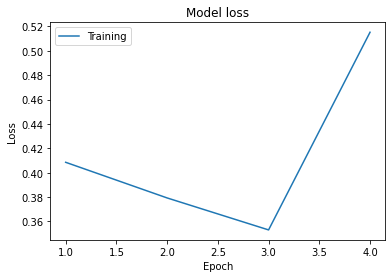

In [11]:
plt.plot(epochs_list, loss_values)
#plt.plot(epochs_list, val_loss_values)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'])
plt.show()

#### Accuracy

Plot the training and validation accuracy

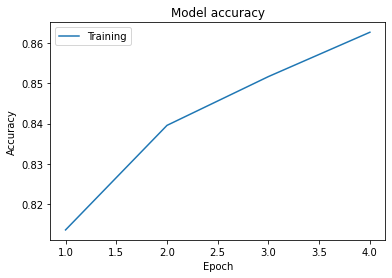

In [12]:
plt.plot(epochs_list, accuracy_values)
#plt.plot(epochs_list, val_accuracy_values)
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'])
plt.show()

## Model validation

Verify the model's performance.

### Load model

Load the pretrained model, tokenizer and test dataset.

#### Load model from disk

Load the model from disk

In [13]:
model = models.load_model(model_file)
model.summary()

Model: "CNN-LSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 256)         12800000  
_________________________________________________________________
conv1d (Conv1D)              (None, None, 200)         256200    
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 200)         0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 200)         200200    
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, None, 200)         0         
_________________________________________________________________
lstm (LSTM)                  (None, 32)                29824     
_________________________________________________________________
dense (Dense)                (None, 1)                 33 

#### Load tokenizer from disk

Load the prefitted tokenizer form disk

In [14]:
with open(tokenizer_file, 'rb') as file:
    tokenizer = pickle.load(file)

#### Load sts-gold test dataset

Load the cleaned STS-Gold dataset and convert it to word vectors

In [15]:
df_test_sts = pd.read_csv(sts_gold_test_csv)

# tokenize, vectorize and pad test texts
test_sts_labels = df_test_sts.polarity
test_sts_tokenized_text = tokenizer.texts_to_sequences(df_test_sts.tweet)
test_sts_data = preprocessing.sequence.pad_sequences(test_sts_tokenized_text, maxlen=max_words)

#### Load sentiment140 test dataset

Load the cleaned sentiment140 test dataset and convert it to word vectors

In [16]:
df_test_140 = pd.read_csv(test_data_csv)

# tokenize, vectorize and pad test texts
test_140_labels = df_test_140.polarity
test_140_tokenized_text = tokenizer.texts_to_sequences(df_test_140.text)
test_140_data = preprocessing.sequence.pad_sequences(test_140_tokenized_text, maxlen=max_words)

### Test model

Verify the model's performance against the test datasets and test it with example phrases

#### STS-Gold dataset test

Evaluate the model against the test dataset

In [17]:
predict_sts = model.predict(test_sts_data) 
sts_predict_classes = (predict_sts > 0.5).astype('int32')

##### STS-Gold Metrics

Calculate and display the evaluation metrics for the STS-Gold dataset

In [18]:
accuracy = metrics.accuracy_score(test_sts_labels, sts_predict_classes)
precision = metrics.precision_score(test_sts_labels, sts_predict_classes)
recall = metrics.recall_score(test_sts_labels, sts_predict_classes)
f1 = metrics.f1_score(test_sts_labels, sts_predict_classes)
roc_auc = metrics.roc_auc_score(test_sts_labels, sts_predict_classes)
cohen_kappa = metrics.cohen_kappa_score(test_sts_labels, sts_predict_classes)

print('Accuracy:\t{:.2%}'.format(accuracy))
print('Precision:\t{:.2%}'.format(precision))
print('Recall:\t\t{:.2%}'.format(recall))
print('F1:\t\t{:.2%}'.format(f1))
print('ROC AUC:\t{:.2%}'.format(roc_auc))
print('Cohen\'s kappa:\t{:.2%}'.format(cohen_kappa))

Accuracy:	95.53%
Precision:	92.73%
Recall:		92.88%
F1:		92.81%
ROC AUC:	94.80%
Cohen's kappa:	89.56%


##### STS-Gold Confusion Matrix

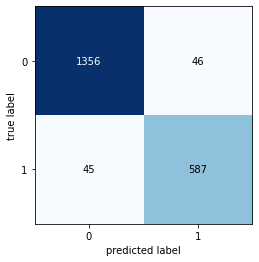

In [19]:
confusion_matrix = metrics.confusion_matrix(test_sts_labels, sts_predict_classes)
fig, ax = plot_confusion_matrix(conf_mat=confusion_matrix)
plt.show()

Calculate and display the confusion matrix

#### Sentiment140 dataset test

Evaluate the model against the Sentiment140 test dataset

In [20]:
predict_s140 = model.predict(test_140_data) 
s140_predict_classes = (predict_s140 > 0.5).astype('int32')

##### Sentiment140 Metrics

Calculate and display the evaluation metrics for the Sentiment140 test dataset

In [21]:
accuracy = metrics.accuracy_score(test_140_labels, s140_predict_classes)
precision = metrics.precision_score(test_140_labels, s140_predict_classes)
recall = metrics.recall_score(test_140_labels, s140_predict_classes)
f1 = metrics.f1_score(test_140_labels, s140_predict_classes)
roc_auc = metrics.roc_auc_score(test_140_labels, s140_predict_classes)
cohen_kappa = metrics.cohen_kappa_score(test_140_labels, s140_predict_classes)

print('Accuracy:\t{:.2%}'.format(accuracy))
print('Precision:\t{:.2%}'.format(precision))
print('Recall:\t\t{:.2%}'.format(recall))
print('F1:\t\t{:.2%}'.format(f1))
print('ROC AUC:\t{:.2%}'.format(roc_auc))
print('Cohen\'s kappa:\t{:.2%}'.format(cohen_kappa))

Accuracy:	82.45%
Precision:	82.87%
Recall:		82.42%
F1:		82.64%
ROC AUC:	82.45%
Cohen's kappa:	64.90%


#####  Sentiment140 Confusion Matrix

Calculate and display the confusion matrix for the Sentiment140 dataset

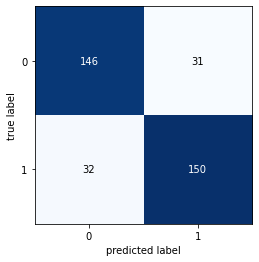

In [22]:
confusion_matrix = metrics.confusion_matrix(test_140_labels, s140_predict_classes)
fig, ax = plot_confusion_matrix(conf_mat=confusion_matrix)
plt.show()

#### Sample predictions

Define a predict function and test the model on a few sample sentences.

##### Predict function

Define a helper function that takes a string and returns a sentiment prediction for it.

In [23]:
def predict(text):
    sequence = tokenizer.texts_to_sequences([text])
    word_vector = preprocessing.sequence.pad_sequences(sequence, maxlen=max_words)
    prediction = model.predict(word_vector)
    return '{:.2%}'.format((prediction)[0][0])

##### Sample predictions

Run the model on a sample of phrases to validate the model's performance when it comes to different language constructs like negation, modal verbs and sarcasm.

In [24]:
phrases = [
    "This movie was horribly good", 
    "I love to hate that book",
    "I hate to admit that he is great",
    "You don't say",
    "Yesterday was awfully bad",
    "On a second thought it was amazingly bad",
    "Tell me something I don’t know",
    "This can't get any better"
]

df_phrases_sentiment = pd.DataFrame(phrases, columns=['phrases'])
df_phrases_sentiment['sentiment'] = df_phrases_sentiment.phrases.map(predict)

df_phrases_sentiment

,phrases,sentiment
0,This movie was horribly good,83.59%
1,I love to hate that book,55.40%
2,I hate to admit that he is great,73.95%
3,You don't say,49.00%
4,Yesterday was awfully bad,12.06%
5,On a second thought it was amazingly bad,52.33%
6,Tell me something I don’t know,75.56%
7,This can't get any better,29.34%


#### Model diagram

Architectural diagram of the model.

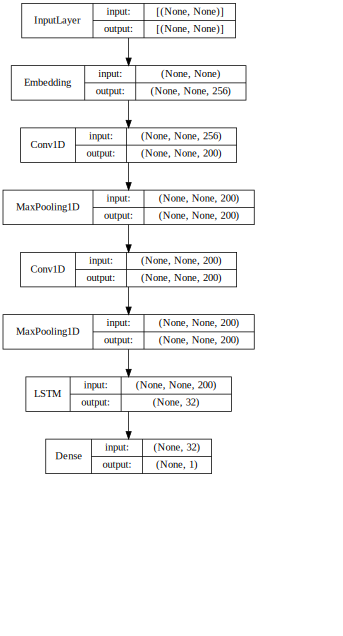

In [25]:
SVG(utils.vis_utils.model_to_dot(model, show_shapes=True,
                                 show_layer_names=False).create(prog='dot', format='svg'))